# Loan Data Prediction Using Regression

The Data file contains complete loan data for all loans issued through the 2007-2011, including the current loan status (Current, Charged-off, Fully Paid, etc.) and the payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter.

#### Abstract

To predict the loan amount to be sanctioned by any lending organization to a member based on the member's previous public and private loan history.

- I plan to use three different regression models; Logistic Regression, Decision Tree Regression, and Random Forest Regression. Based on those models I plan to predict the loan amount to be sanctioned for future loans. 

### Importing Libraries

In [98]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Importing Data 

In [266]:
!pip install -q kaggle

In [267]:
from google.colab import files

In [269]:
!mkdir ~/.kaggle

In [270]:
! cp kaggle.json ~/.kaggle/

In [271]:
! chmod 600 ~/.kaggle/kaggle.json

In [274]:
!kaggle datasets download -d imsparsh/lending-club-loan-dataset-2007-2011

100% 8.39M/8.39M [00:00<00:00, 16.1MB/s]



In [276]:
!mkdir train

mkdir: cannot create directory ‘train’: File exists


In [277]:
!unzip lending-club-loan-dataset-2007-2011.zip -d train

Archive:  lending-club-loan-dataset-2007-2011.zip
  inflating: train/Data_Dictionary.xlsx  
  inflating: train/loan.csv          


In [278]:
data = pd.read_csv('train/loan.csv')

In [279]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [280]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,90.000000,9.000000,0.0000

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


### Analyzing Data

In [191]:
data.corr()['loan_amnt'][1:40].sort_values()

pub_rec                       -0.051236
delinq_2yrs                   -0.031864
mths_since_last_record         0.004968
inq_last_6mths                 0.009229
mths_since_last_delinq         0.014871
total_rec_late_fee             0.044706
dti                            0.066439
collection_recovery_fee        0.072853
recoveries                     0.135446
member_id                      0.140710
open_acc                       0.177168
out_prncp_inv                  0.192623
out_prncp                      0.192937
total_acc                      0.256442
annual_inc                     0.271149
revol_bal                      0.317597
last_pymnt_amnt                0.448742
total_rec_int                  0.729726
total_rec_prncp                0.852021
total_pymnt_inv                0.854243
total_pymnt                    0.886613
installment                    0.930288
funded_amnt_inv                0.940034
funded_amnt                    0.981578
loan_amnt                      1.000000


Selecting features to check correlation

In [192]:
features = data[['pub_rec','delinq_2yrs',                  
'mths_since_last_record',                  
'inq_last_6mths',                      
'mths_since_last_delinq',                
'total_rec_late_fee',                     
'dti',                                      
'collection_recovery_fee',       
'recoveries',                    
'member_id',                     
'open_acc',                      
'out_prncp_inv',                 
'out_prncp',                     
'total_acc',                     
'annual_inc',                     
'revol_bal',                   
'last_pymnt_amnt',                
'total_rec_int' ,                
'total_rec_prncp',                
'total_pymnt_inv',               
'total_pymnt',                    
'installment','funded_amnt_inv','funded_amnt','loan_amnt']]

Plotting the correlation matrix

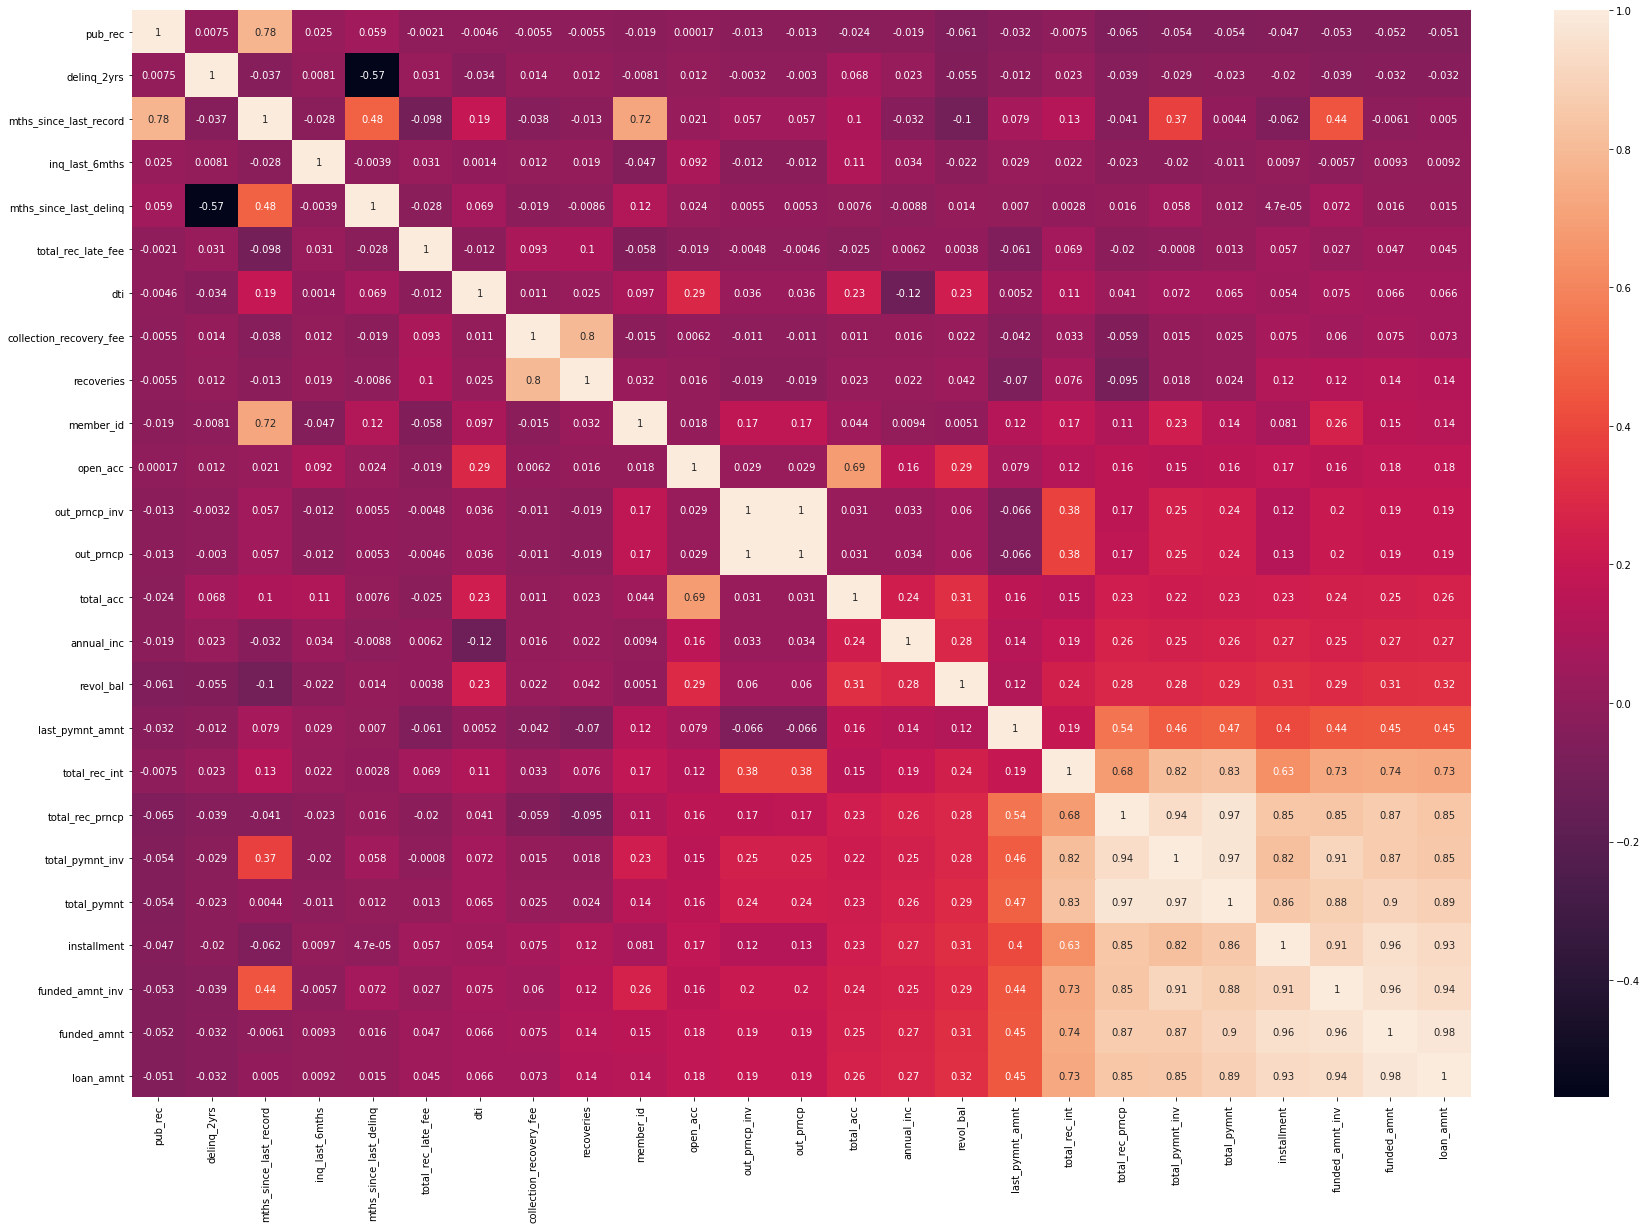

In [204]:
plt.figure(figsize=(30,20))
sns.heatmap(features.corr(),annot=True)

Selecting the final features

The co-relation matrix reveals that 'member_id', 'collection_recovery_fee','installment', 'delinq_2yrs', 'pub_rec', 'annual_inc', 'dti', 'open_acc', 'total_pymnt', 'revol_bal' are dependent variable and 'pub_rec', 'delinq_2yrs' are independent variables regarding the target variable Loan_amnt



In [194]:
df = data[['member_id','loan_amnt','collection_recovery_fee','installment','delinq_2yrs','pub_rec',
            'annual_inc','dti','open_acc','total_pymnt','revol_bal']]

In [195]:
df.head()

,member_id,loan_amnt,collection_recovery_fee,installment,delinq_2yrs,pub_rec,annual_inc,dti,open_acc,total_pymnt,revol_bal
0,1296599,5000,0.00,162.87,0,0,24000.0,27.65,3,5863.155187,13648
1,1314167,2500,1.11,59.83,0,0,30000.0,1.00,3,1008.710000,1687
2,1313524,2400,0.00,84.33,0,0,12252.0,8.72,2,3005.666844,2956
3,1277178,10000,0.00,339.31,0,0,49200.0,20.00,10,12231.890000,5598
4,1311748,3000,0.00,67.79,0,0,80000.0,17.94,15,3513.330000,27783


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   member_id                39717 non-null  int64  
 1   loan_amnt                39717 non-null  int64  
 2   collection_recovery_fee  39717 non-null  float64
 3   installment              39717 non-null  float64
 4   delinq_2yrs              39717 non-null  int64  
 5   pub_rec                  39717 non-null  int64  
 6   annual_inc               39717 non-null  float64
 7   dti                      39717 non-null  float64
 8   open_acc                 39717 non-null  int64  
 9   total_pymnt              39717 non-null  float64
 10  revol_bal                39717 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 3.3 MB


Plotting the heatmap of the selected features

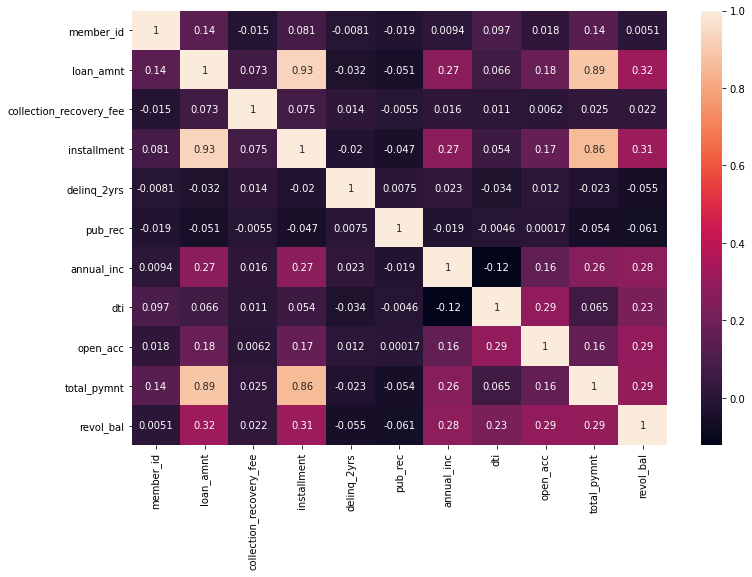

In [197]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

Checking the ranges for the target variable 

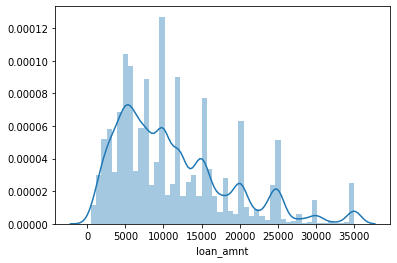

In [198]:
sns.distplot(df['loan_amnt'],kde=True)

In [199]:
df.corr()['loan_amnt'].sort_values()

pub_rec                   -0.051236
delinq_2yrs               -0.031864
dti                        0.066439
collection_recovery_fee    0.072853
member_id                  0.140710
open_acc                   0.177168
annual_inc                 0.271149
revol_bal                  0.317597
total_pymnt                0.886613
installment                0.930288
loan_amnt                  1.000000
Name: loan_amnt, dtype: float64

Selected Features Description
- installment -	The monthly payment owed by the borrower if the loan originates.
- loan_amnt -	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- total_pymnt	- Payments received to date for total amount funded
- revol_bal	- Total credit revolving balance
- annual_inc	- The self-reported annual income provided by the borrower during registration.
- open_acc -	The number of open credit lines in the borrower's credit file.
- member_id	- A unique LC assigned Id for the borrower member.
- collection_recovery_fee -	post charge off collection fee
- dti -	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- delinq_2yrs -	The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- pub_rec -	Number of derogatory public records


Checking the codependency of collection_recovery_fee and the loan_amount 

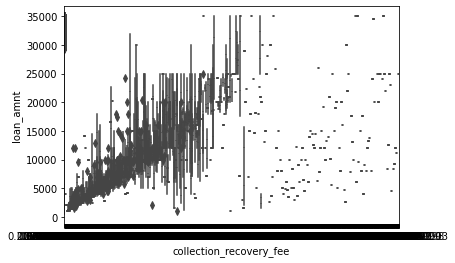

In [201]:
sns.boxplot(x='collection_recovery_fee',y='loan_amnt',data=df)

Check the codependency of the final features with each other

In [202]:
sns.pairplot(df)

Output hidden; open in https://colab.research.google.com to view.

Checking for null values

In [203]:
df.isnull().sum()

member_id                  0
loan_amnt                  0
collection_recovery_fee    0
installment                0
delinq_2yrs                0
pub_rec                    0
annual_inc                 0
dti                        0
open_acc                   0
total_pymnt                0
revol_bal                  0
dtype: int64

### Splitting the dataset into the Training set and Test set

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [123]:
X = df.drop('loan_amnt',axis=1)[:10000]
y = df['loan_amnt'][:10000]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

### Logistic Regression Model

In [125]:
import statsmodels.api as sm
lrm_data = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())

In [126]:
lrm_data.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              loan_amnt   No. Observations:                 7000
Model:                            GLM   Df Residuals:                     6989
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 27 Sep 2020   Deviance:                   8.1907e+09
Time:                        01:06:29   Pearson chi2:                 7.44e+27
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1.926e+19   1.12e+07   1.72e+12      0.000    1.93e+19    1.93e+19
member_id               -1.595e+13      9.177  -1.74e+12      0.000   -1.59e+13   -1.59e+13
collection_recovery_fee  2.347e+16   7308.147   3.21e+12      0.000    2.35e+16    2.35e+16
installment              1.683e+17   7083.424   2.38e+13      0.000    1.68e+17    1.68e+17
delinq_2yrs             -1.688e+18   1.78e+06  -9.49e+11      0.000   -1.69e+18   -1.69e+18
pub_rec                 -3.078e+17   3.73e+06  -8.25e+10      0.000   -3.08e+17   -3.08e+17
annual_inc              -1.058e+12     21.709  -4.87e+10      0.000   -1.06e+12   -1.06e+12
dti                      4.505e+16   1.36e+05   3.31e+11      0.000     4.5e+16     4.5e+16
open_acc                -2.441e+16   2.07e+05  -1.18e+11      0.000   -2.44e+16   -2.44e+16
total_pymnt               1.73e+15    150.295   1.15e+13      0.000    1.73e+15    1.73e+15
revol_bal                4.392e+13     62.356   7.04e+11      0.000    4.39e+13    4.39e+13
===========================================================================================
"""

In [127]:
from sklearn.linear_model import LogisticRegression

In [128]:
regressor1 = LogisticRegression()

Training the model on default parameters

In [129]:
regressor1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting using default parameters

In [130]:
y_pred_1 = regressor1.predict(X_test)

In [131]:
print(mean_absolute_error(y_test,y_pred_1))
print(np.sqrt(mean_squared_error(y_test,y_pred_1)))
print(explained_variance_score(y_test,y_pred_1))

4595.141666666666
6335.514564079753
0.44236945600457134


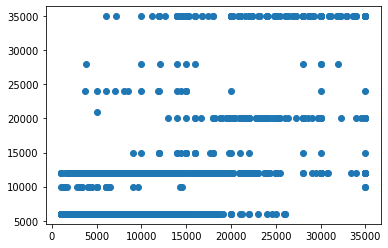

In [132]:
plt.scatter(y_test,y_pred_1)

Hyperparameter Tuning for Logistic Regression

In [133]:
from sklearn.model_selection import GridSearchCV

In [134]:
params = {
    'penalty':['l1', 'l2', 'elasticnet'],        # l1 is Lasso, l2 is Ridge
    'solver':['liblinear'],
    'C':[0.001,0.01,0.1,1,10]
}

In [135]:
lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=3, verbose=1).fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 10.8min finished


In [136]:
lr_gs_results = pd.DataFrame(lr_gs.cv_results_)
lr_gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.952964,0.176795,0.009921,0.000242,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.132391,0.132019,0.122589,0.129000,0.004536,5
1,10.314098,0.154113,0.010000,0.000170,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.132391,0.126447,0.121732,0.126856,0.004361,8
2,0.001995,0.000204,0.000000,0.000000,0.001,elasticnet,liblinear,"{'C': 0.001, 'penalty': 'elasticnet', 'solver'...",NaN,NaN,NaN,NaN,NaN,11
3,8.749501,0.468008,0.009956,0.000141,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.138389,0.146592,0.130733,0.138571,0.006476,4
4,10.371056,0.065825,0.009924,0.000240,0.01,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.125536,0.136305,0.115302,0.125714,0.008575,9
5,0.001981,0.000219,0.000000,0.000000,0.01,elasticnet,liblinear,"{'C': 0.01, 'penalty': 'elasticnet', 'solver':...",NaN,NaN,NaN,NaN,NaN,12
6,16.645445,0.665833,0.010093,0.000066,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.140531,0.150879,0.137162,0.142857,0.005836,3
7,10.432036,0.120945,0.009738,0.000077,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.126821,0.132447,0.116159,0.125143,0.006755,10
8,0.001944,0.000173,0.000000,0.000000,0.1,elasticnet,liblinear,"{'C': 0.1, 'penalty': 'elasticnet', 'solver': ...",NaN,NaN,NaN,NaN,NaN,13
9,42.969676,2.987872,0.009926,0.000082,1,l1,liblinear,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.140960,0.147878,0.142735,0.143858,0.002934,2


In [137]:
print("Best Params", lr_gs.best_params_)
print("Best Score", lr_gs.best_score_)

Best Params {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score 0.14600035284756677


Training and predicting the model using the best parameters

In [138]:
lr_best = LogisticRegression(C= 1, penalty= 'l1', solver= 'liblinear')
lr_best.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
y_pred_best_1 = lr_best.predict(X_test)

In [140]:
print(mean_absolute_error(y_test,y_pred_best_1))
print(np.sqrt(mean_squared_error(y_test,y_pred_best_1)))
print(explained_variance_score(y_test,y_pred_best_1))

3476.616666666667
4972.360690188649
0.6563160733042035


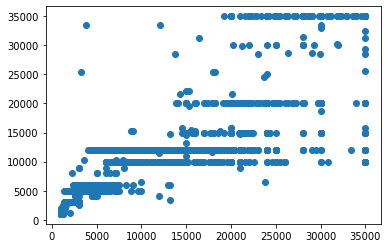

In [141]:
plt.scatter(y_test,y_pred_best_1)

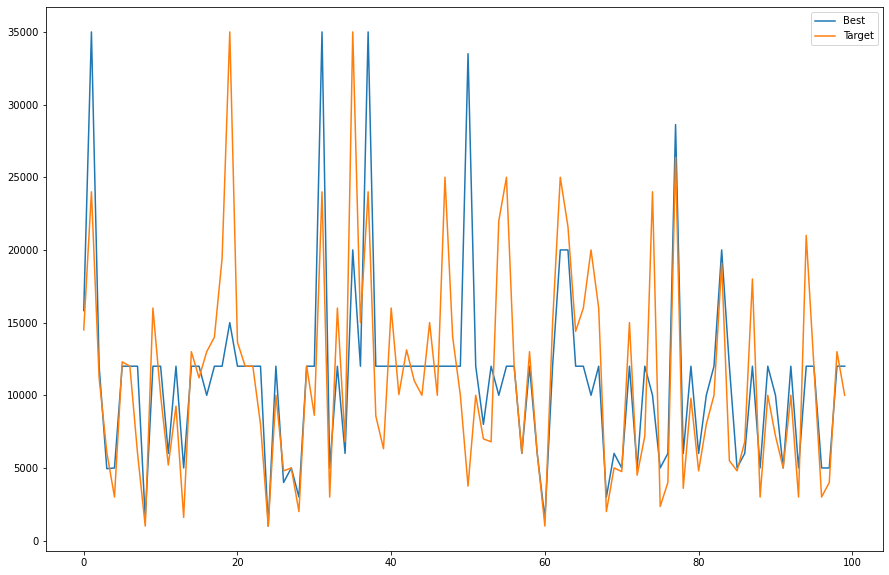

In [258]:
# Comparison of Target value vs Predicted values
lr_table = pd.DataFrame({'Predict_values':y_pred_best_1,'Actual_values':y_test})
fig= plt.figure(figsize=(15,10))
predicting_vs_actual_lr = lr_table.reset_index()
predicting_vs_actual_lr = predicting_vs_actual_lr.drop(['index'],axis=1)
plt.plot(predicting_vs_actual_lr[:100])
plt.legend(('Best', 'Target'))

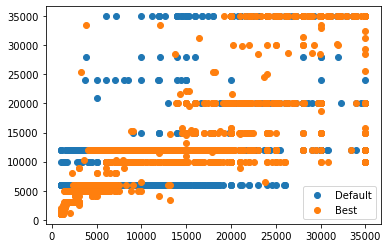

In [255]:
# Comparison of Defualt vs Best Parameters Prediction values
plt.scatter(y_test,y_pred_1)
plt.scatter(y_test,y_pred_best_1)
plt.legend(('Default','Best'))

### Decision Tree Regression

Training the model on default parameters

In [252]:
from sklearn.tree import DecisionTreeRegressor
regressor2 = DecisionTreeRegressor()
regressor2.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Predicting using default parameters

In [148]:
y_pred_2 = regressor2.predict(X_test)

In [149]:
print(mean_absolute_error(y_test,y_pred_2))
print(np.sqrt(mean_squared_error(y_test,y_pred_2)))
print(explained_variance_score(y_test,y_pred_2))

0.0
0.0
1.0


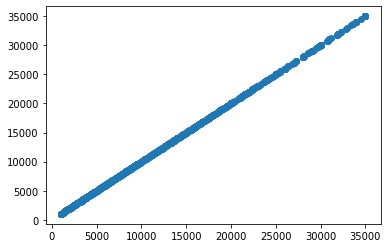

In [150]:
plt.scatter(y_test,y_pred_2)

In [152]:
param_dtr = [{'max_depth': np.arange(3, 10),
              'max_leaf_nodes':[1,10,25,50,100]}]

In [153]:
dtr = DecisionTreeRegressor()
dtr_gs = GridSearchCV(dtr, param_dtr, cv=2, verbose=1).fit(X_train, y_train)

Fitting 2 folds for each of 35 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.8s finished


In [167]:
dtr_gs_results = pd.DataFrame(dtr_gs.cv_results_)
dtr_gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003398,0.000966,0.000000,0.000000e+00,3,1,"{'max_depth': 3, 'max_leaf_nodes': 1}",NaN,NaN,NaN,NaN,35
1,0.008966,0.000340,0.001411,2.491474e-05,3,10,"{'max_depth': 3, 'max_leaf_nodes': 10}",0.905326,0.895340,0.900333,0.004993,25
2,0.008749,0.000079,0.001387,4.172325e-06,3,25,"{'max_depth': 3, 'max_leaf_nodes': 25}",0.905326,0.895340,0.900333,0.004993,25
3,0.008506,0.000112,0.001327,6.842613e-05,3,50,"{'max_depth': 3, 'max_leaf_nodes': 50}",0.905326,0.895340,0.900333,0.004993,25
4,0.008649,0.000207,0.001355,5.125999e-05,3,100,"{'max_depth': 3, 'max_leaf_nodes': 100}",0.905326,0.895340,0.900333,0.004993,25
5,0.002505,0.000497,0.000000,0.000000e+00,4,1,"{'max_depth': 4, 'max_leaf_nodes': 1}",NaN,NaN,NaN,NaN,31
6,0.010599,0.000173,0.001396,7.033348e-06,4,10,"{'max_depth': 4, 'max_leaf_nodes': 10}",0.912490,0.905247,0.908869,0.003621,19
7,0.010740,0.000009,0.001384,1.192093e-07,4,25,"{'max_depth': 4, 'max_leaf_nodes': 25}",0.928276,0.924928,0.926602,0.001674,16
8,0.010457,0.000068,0.001324,3.087521e-05,4,50,"{'max_depth': 4, 'max_leaf_nodes': 50}",0.928276,0.924928,0.926602,0.001674,16
9,0.010470,0.000135,0.001365,5.364418e-05,4,100,"{'max_depth': 4, 'max_leaf_nodes': 100}",0.928276,0.924928,0.926602,0.001674,16


In [168]:
print("Best Params", dtr_gs.best_params_)
print("Best Score", dtr_gs.best_score_)

Best Params {'max_depth': 6, 'max_leaf_nodes': 100}
Best Score 0.9397582222051385


Training and predicting the model using the Best parameters

In [169]:
dtr_best = DecisionTreeRegressor(max_depth= 6, max_leaf_nodes= 100)
dtr_best.fit(X_train, y_train)
dtr_best.score(X_test, y_test)

0.9449879487303733

In [170]:
y_pred_best_2 = dtr_best.predict(X_test)

In [171]:
print(mean_absolute_error(y_test,y_pred_best_2))
print(np.sqrt(mean_squared_error(y_test,y_pred_best_2)))
print(explained_variance_score(y_test,y_pred_best_2))

1060.4527962432223
1989.3121695485004
0.945026596557953


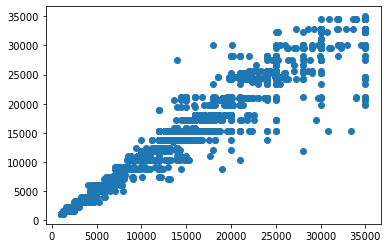

In [172]:
plt.scatter(y_test,y_pred_best_2)

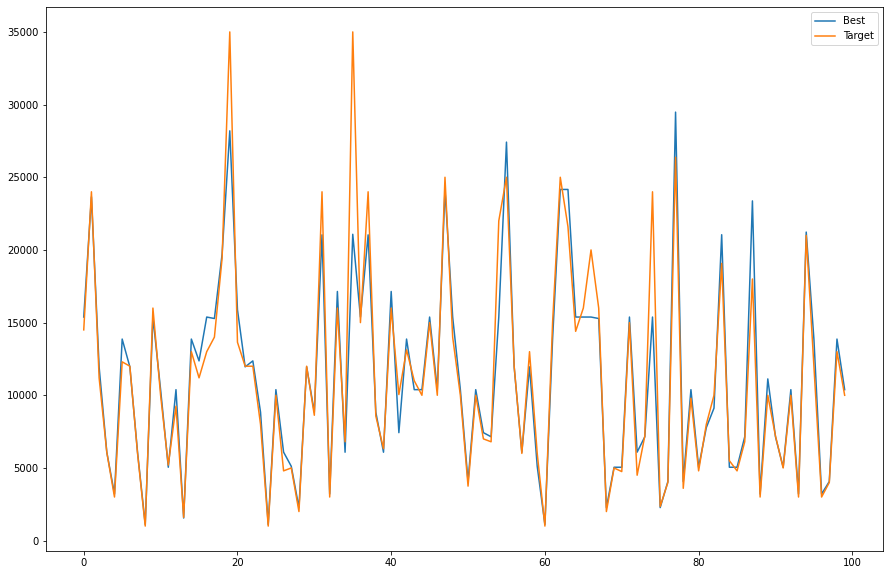

In [263]:
# Comparison of Target value vs Predicted values
dtr_table = pd.DataFrame({'Predict_values':y_pred_best_2,'Actual_values':y_test})
fig= plt.figure(figsize=(15,10))
predicting_vs_actual_dtr = dtr_table.reset_index()
predicting_vs_actual_dtr = predicting_vs_actual_dtr.drop(['index'],axis=1)
plt.plot(predicting_vs_actual_dtr[:100])
plt.legend(('Best', 'Target'))

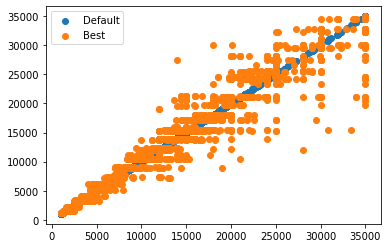

In [261]:
# Comparison of Defualt vs Best Parameters Prediction values
plt.scatter(y_test,y_pred_2)
plt.scatter(y_test,y_pred_best_2)
plt.legend(('Default','Best'))

### Random Forest Regression

Training the model using default parameters

In [254]:
from sklearn.ensemble import RandomForestRegressor
regressor3 = RandomForestRegressor()
regressor3.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Predicting using default parameters

In [176]:
y_pred_3 = regressor3.predict(X_test)

In [177]:
print(mean_absolute_error(y_test,y_pred_3))
print(np.sqrt(mean_squared_error(y_test,y_pred_3)))
print(explained_variance_score(y_test,y_pred_3))

303.31241666666665
620.6435262592369
0.994646822455858


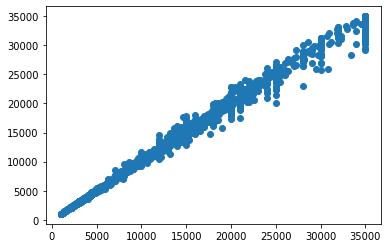

In [178]:
plt.scatter(y_test,y_pred_3)

Hyperparameter Tuning for Random Forest Regression

In [179]:
param_rfr = [{ 'n_estimators' : [2,10,20,50,100],
              'max_depth': np.arange(3, 10),
              'max_leaf_nodes':[1,10,25,50,100]}]

In [180]:
rfr = RandomForestRegressor()
rfr_gs = GridSearchCV(rfr, param_rfr, cv=3, verbose=0).fit(X_train, y_train)

In [181]:
rfr_gs_results = pd.DataFrame(rfr_gs.cv_results_)
rfr_gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004545,0.000920,0.000000,0.000000,3,1,2,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,175
1,0.006048,0.000164,0.000000,0.000000,3,1,10,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,141
2,0.009299,0.000274,0.000000,0.000000,3,1,20,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,151
3,0.019579,0.000206,0.000000,0.000000,3,1,50,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,145
4,0.035158,0.000675,0.000000,0.000000,3,1,100,"{'max_depth': 3, 'max_leaf_nodes': 1, 'n_estim...",NaN,NaN,NaN,NaN,NaN,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0.031154,0.000387,0.002121,0.000080,9,100,2,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.948839,0.942313,0.940070,0.943741,0.003720,69
171,0.146354,0.000613,0.003832,0.000060,9,100,10,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.957385,0.953431,0.950958,0.953924,0.002647,21
172,0.286255,0.001397,0.005730,0.000012,9,100,20,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.958707,0.955601,0.953045,0.955784,0.002315,7
173,0.714992,0.003873,0.011071,0.000122,9,100,50,"{'max_depth': 9, 'max_leaf_nodes': 100, 'n_est...",0.960222,0.956480,0.953105,0.956602,0.002907,3


In [182]:
print("Best Params", rfr_gs.best_params_)
print("Best Score", rfr_gs.best_score_)

Best Params {'max_depth': 9, 'max_leaf_nodes': 100, 'n_estimators': 100}
Best Score 0.9567649575123526


Training and predicting the model using the Best parameters

In [183]:
rfr_best = RandomForestRegressor(max_depth= 9, max_leaf_nodes= 100,n_estimators=100)
rfr_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=100,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [184]:
y_pred_best_3 = rfr_best.predict(X_test)

In [185]:
print(mean_absolute_error(y_test,y_pred_best_3))
print(np.sqrt(mean_squared_error(y_test,y_pred_best_3)))
print(explained_variance_score(y_test,y_pred_best_3))

892.8009623129977
1728.955314008838
0.9584458231075165


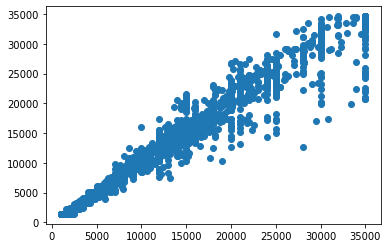

In [186]:
plt.scatter(y_test,y_pred_best_3)

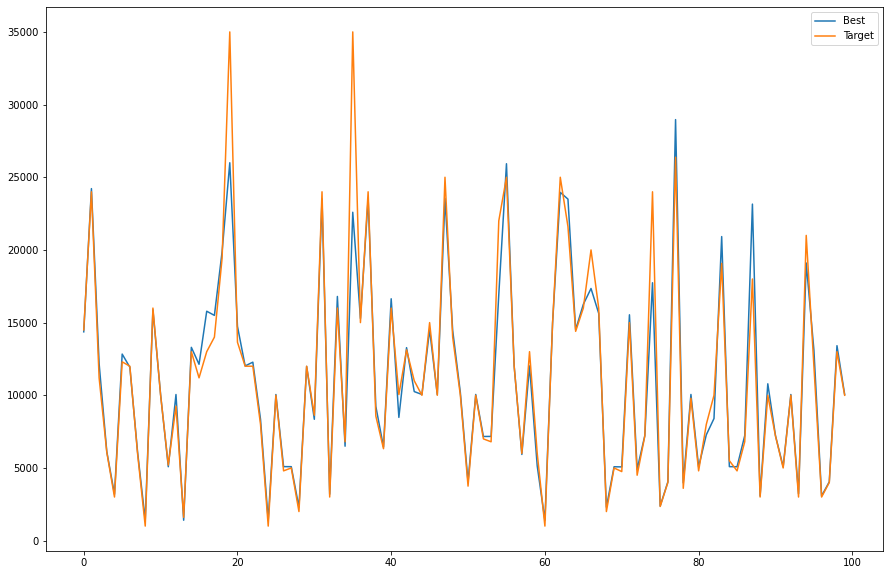

In [260]:
rfr_table = pd.DataFrame({'Predict_values':y_pred_best_3,'Actual_values':y_test})
fig= plt.figure(figsize=(15,10))
predicting_vs_actual_rfr = rfr_table.reset_index()
predicting_vs_actual_rfr = predicting_vs_actual_rfr.drop(['index'],axis=1)
plt.plot(predicting_vs_actual_rfr[:100])
plt.legend(('Best', 'Target'))

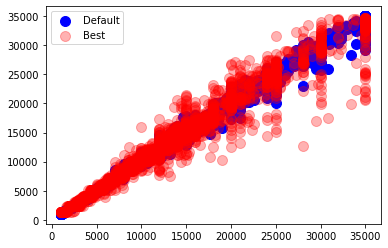

In [259]:
# Comparison of Defualt vs Best Parameters Prediction values
plt.scatter(y_test,y_pred_3,s=100, color="blue", alpha=1)
plt.scatter(y_test,y_pred_best_3,s=100, color="red", alpha=0.3)
plt.legend(('Default','Best'))

### Prediction Test

In [211]:
def prediction_print(x):
    print("Real Loan amount : " + str(y_test.iloc[x]))
    print("Predicted amount using Best Parameters for Logistic Regression : " + str(y_pred_best_1[x]))
    print("Predicted amount using Best Parameters Decision Tree Regression : " + str(y_pred_best_2[x]))
    print("Predicted amount using Best Parameters Random Forest Regression : " + str(y_pred_best_3[x]))

In [208]:
prediction_print(10)

Real Loan amount : 10000
Predicted amount using default Parameters for Logistic Regression : 12000
Predicted amount using Best Parameters for Logistic Regression : 12000
Predicted amount using default Parameters for Decision Tree Regression : 10000.0
Predicted amount using Best Parameters Decision Tree Regression : 10386.499215070644
Predicted amount using default Parameters for Random Forest Regression : 10000.0
Predicted amount using Best Parameters Random Forest Regression : 10049.166509056653


### Evaluation

We used three different metrics to evaluate our models; mean_squared_error,mean_absolute_error, and explained_variance_score.

- **mean_squared_error** : It tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. It’s called the mean squared error as you’re finding the average of a set of errors.

- **mean_absolute_error** : It is a measure of errors between paired observations expressing the same phenomenon.

- **explained_variance_score** : It is used to measure the discrepancy between a model and actual data.

**Logistic Regression :** 

We tried training the model using default parameters which led to a very poor result, where the explained_variance_score was 0.44. Later we tried tuning the hyperparameters and used GridSearch CV to get the best parameter combination that led to a better explained_variance_score of 0.65.

Best parameter combination : <I>Best Params {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}</I>

**Decision Tree Regression :** 

We tried training the model using default parameters which led to overfitting, where the explained_variance_score was 1. Later we tried tuning the hyperparameters and used GridSearch CV to get the best parameter combination that led to a better explained_variance_score of 0.94. Therefore, we were able to avoid overfitting.

Best parameter combination : <I>Best Params {'max_depth': 6, 'max_leaf_nodes': 100}</I>

**Random Forest Regression :** 

We tried training the model using default parameters which led to overfitting, where the explained_variance_score was 1. Later we tried tuning the hyperparameters and used GridSearch CV to get the best parameter combination that led to a better explained_variance_score of 0.95. Therefore, we were able to avoid overfitting.

Best parameter combination : <I>Best Params {'max_depth': 9, 'max_leaf_nodes': 100, 'n_estimators': 100}</I>

 
 


### Conclusion



We observed that Installment feature, is most important feature to predict the loan amount, It's possible to predict the loan amount that should be sanctioned to a individual based on his/her's previous loan repayment history


### Code Citation: 

All the code is written by me, but I have adapted to the documentation of the libraries imported. 

- 1. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- 2. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- 3. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html
- 4. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- 5. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- 6. https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
- 7. https://scikit-learn.org/stable/modules/grid_search.html
- 8. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
